`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


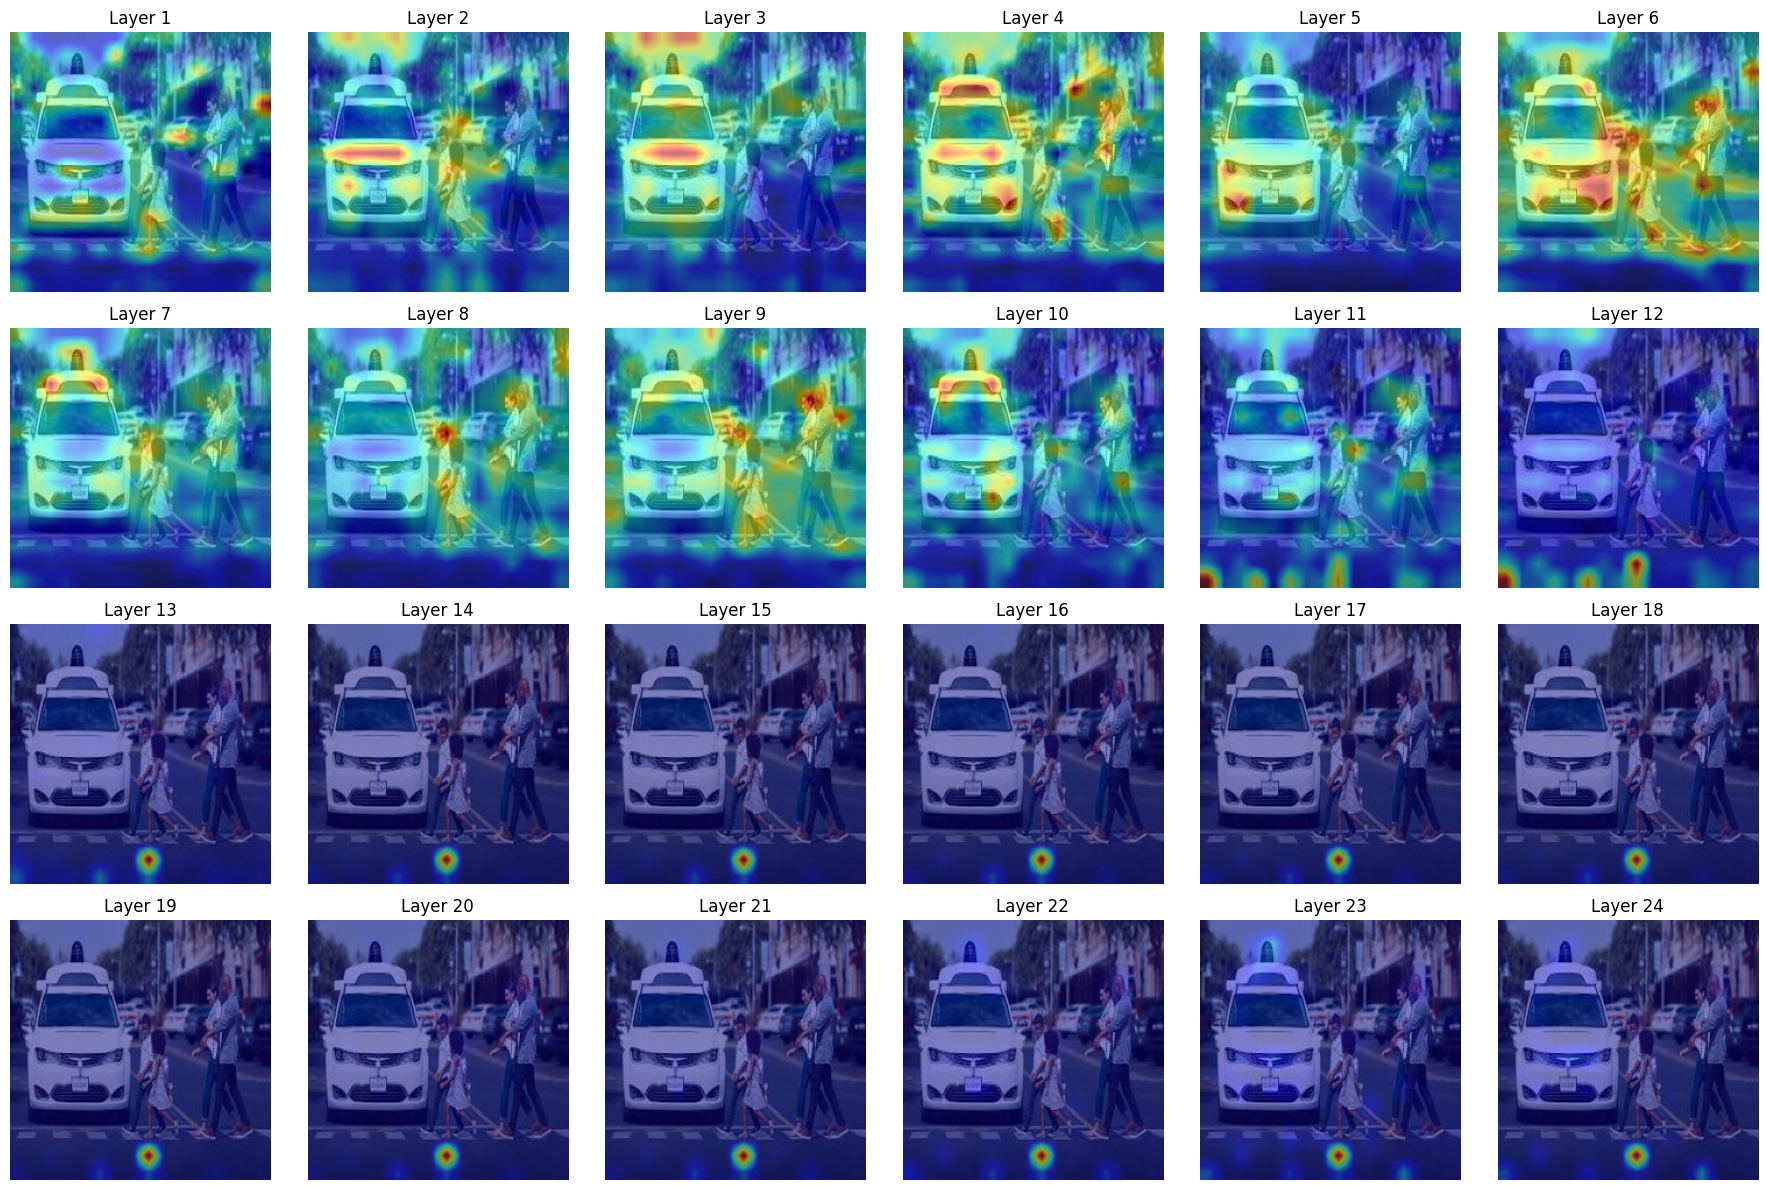

In [27]:
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ---------- 参数 ----------
image_path = "carhuman_224.jpg"  # 你要处理的图片路径
model_name = "openai/clip-vit-large-patch14"
resize_hw = 224
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 加载模型 ----------
model = CLIPModel.from_pretrained(model_name).vision_model
model.eval().to(device)

processor = CLIPProcessor.from_pretrained(model_name)

# ---------- 图像预处理 ----------
raw_image = Image.open(image_path).convert("RGB")
resized_image = raw_image.resize((resize_hw, resize_hw))
inputs = processor(images=resized_image, return_tensors="pt").to(device)

# ---------- 前向传播：开启 attentions ----------
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions  # list of [1, 12, N, N]

# ---------- 提取每一层 attention heatmap ----------
resized_heatmaps = []

for attn in attentions:
    cls_attn = attn[:, :, 0, 1:]   # shape: [1, heads, N_patch]
    cls_attn = cls_attn.mean(dim=1)  # → [1, N_patch]
    n_patch = cls_attn.shape[-1]
    patch_hw = int(n_patch ** 0.5)
    assert patch_hw * patch_hw == n_patch, "Patch数不是平方数"

    cls_attn_map = cls_attn.reshape(1, 1, patch_hw, patch_hw)  # [1, 1, H, W]
    upsampled = F.interpolate(cls_attn_map, size=(resize_hw, resize_hw), mode='bilinear', align_corners=False)
    resized_heatmaps.append(upsampled.squeeze().cpu().numpy())  # [224, 224]

# ---------- 可视化所有层 ----------
show_layers = len(resized_heatmaps)  # 自动获取总层数
cols = 6
rows = (show_layers + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for i in range(rows * cols):
    ax = axs[i // cols, i % cols]
    if i < show_layers:
        ax.imshow(resized_image)
        ax.imshow(resized_heatmaps[i], cmap='jet', alpha=0.5)
        ax.set_title(f"Layer {i+1}")
    else:
        ax.axis("off")
    ax.axis("off")

plt.tight_layout()
plt.show()




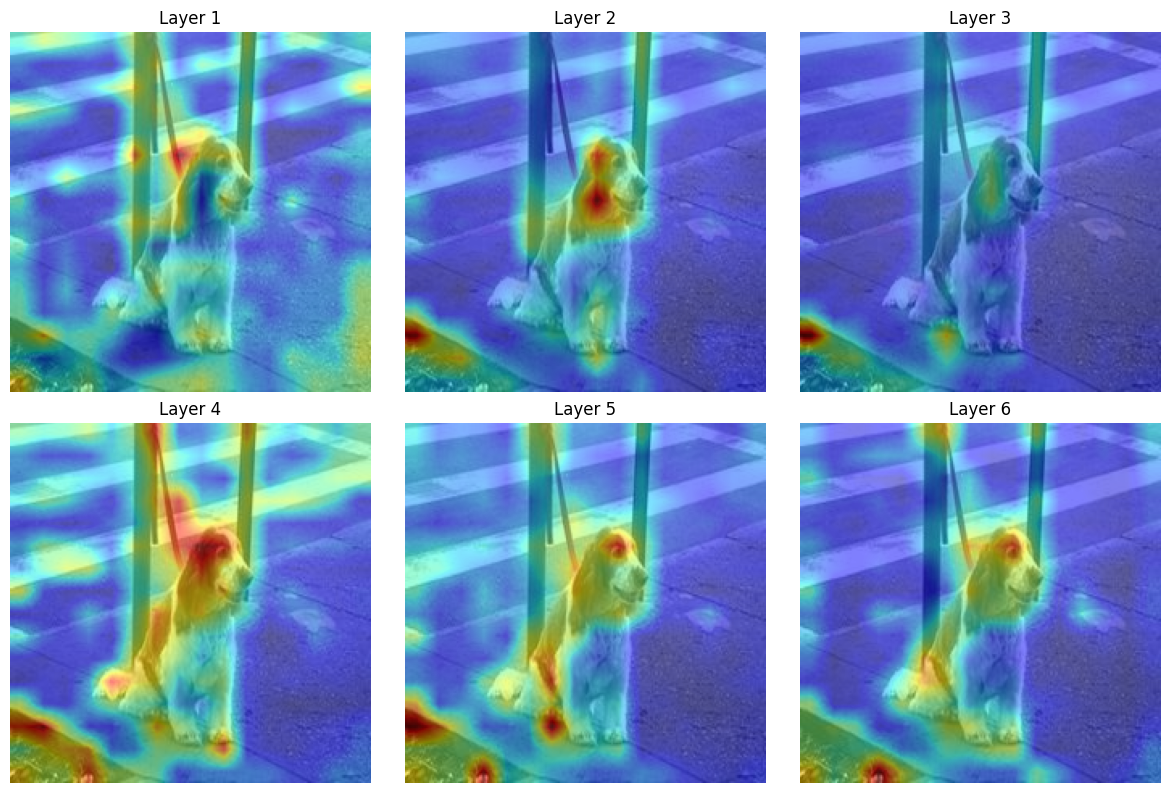

In [26]:
from PIL import Image

# 打开原始图像
img = Image.open("carhuman.jpeg").convert("RGB")

# resize 成 224x224 大小
img = img.resize((224, 224), Image.BICUBIC)

# 保存为新的文件
img.save("carhuman_224.jpg")
